In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Chaplin Filter - RF train

Load in the data first and plot an HR diagram.

In [3]:
data_file = 'chaplinfilter/Data/jitterdata_box4.txt'
df = pd.read_csv(data_file, sep='\s+')
df.head()

,Mass,Radius,Teff,logg,L,tp1,tpE
0,0.7,0.665300,4365.16,4.639,0.141254,2.08333,2.08333
1,0.7,0.683152,4405.55,4.616,0.155239,2.08333,2.08333
2,0.7,0.703911,4466.84,4.590,0.172982,2.08333,2.08333
3,0.8,0.718644,4797.33,4.630,0.240991,2.08333,2.08333
4,0.8,0.742187,4841.72,4.602,0.266686,2.21484,2.08333


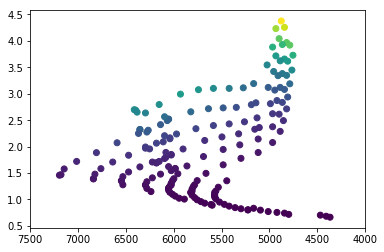

In [4]:
fig, ax = plt.subplots()
ax.scatter(df.Teff, df.Radius, c=df.tpE, cmap='viridis')
ax.set_xlim([7500, 4000])
plt.show()

Now let's train a rendom forest to take Teff, logg, and L as inputs and output tpE.  Hyperparameters (n_estimators, max_depth) are largely unimportant here - we could setup a grid to train these in the real code but it's probably not neccessary.

In [38]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor(n_estimators=400, max_depth=20, random_state=53
                             , oob_score=True, criterion='mae')

In [39]:
labels = np.array(['Teff', 'logg', 'L'])
X = df[labels].values
y = df[['tpE']].values
regr.fit(X, y)
print(f'OOB Score: {regr.oob_score_}')

/home/davies/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


OOB Score: 0.9865074706988736


The OOB score of ~.98 is good (1.0 would be perfect). 

(-1, 3)

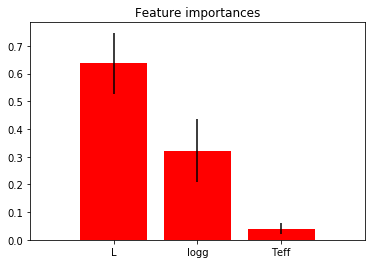

In [40]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], 
        align="center", tick_label=labels[indices])
plt.xlim([-1, X.shape[1]])

Interesting note from the feature importances: Teff is not important.  We could probably do this with just logg and L.

Let's check the output from the RF ...

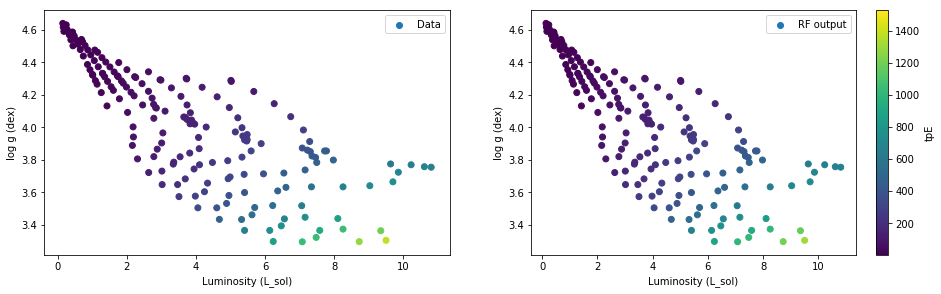

In [41]:
fig, ax = plt.subplots(1, 2, figsize=[16,4.5])
tpmin, tpmax = df.tpE.min()*0.9, df.tpE.max()*1.1
CS = ax[0].scatter(df.L, df.logg, c=df.tpE, cmap='viridis', 
                   vmin=tpmin, vmax=tpmax,
                  label='Data')
ax[1].scatter(df.L, df.logg, c=regr.predict(X), cmap='viridis', 
              vmin=tpmin, vmax=tpmax,
             label='RF output')
ax[1].set_xlabel('Luminosity (L_sol)')
ax[1].set_ylabel('log g (dex)')
ax[0].set_xlabel('Luminosity (L_sol)')
ax[0].set_ylabel('log g (dex)')
ax[0].legend()
ax[1].legend()
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('tpE')
plt.show()

Now let's look at the differences ...

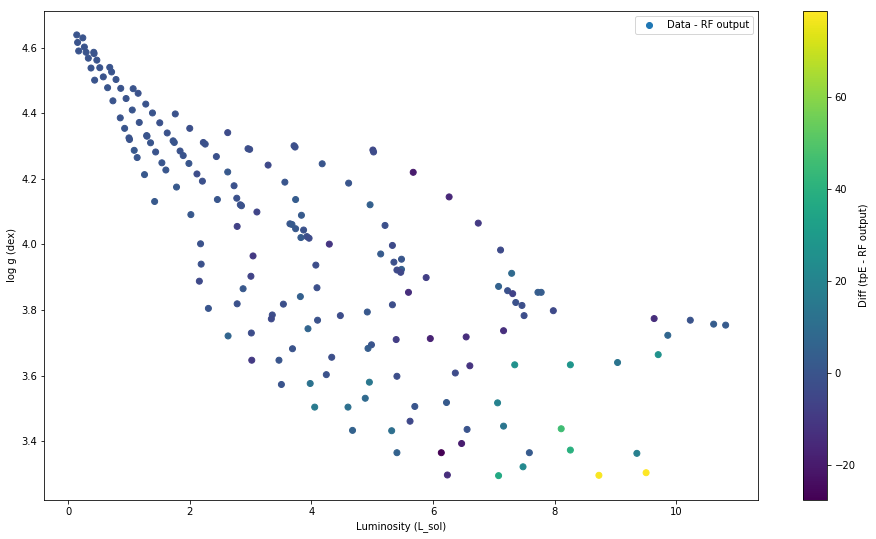

In [42]:
fig, ax = plt.subplots(figsize=[16,9])
CS = ax.scatter(df.L, df.logg, c=df.tpE - regr.predict(X), cmap='viridis', 
                  label='Data - RF output')
ax.set_xlabel('Luminosity (L_sol)')
ax.set_ylabel('log g (dex)')
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Diff (tpE - RF output)')
ax.legend()

Now fractional differences

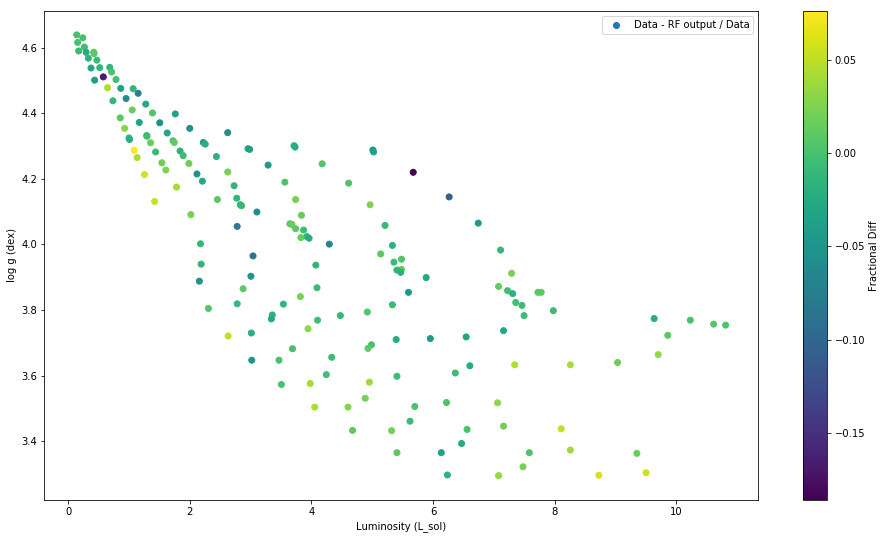

In [43]:
fig, ax = plt.subplots(figsize=[16,9])
CS = ax.scatter(df.L, df.logg, c=(df.tpE - regr.predict(X)) / df.tpE, cmap='viridis', 
                  label='Data - RF output / Data')
ax.set_xlabel('Luminosity (L_sol)')
ax.set_ylabel('log g (dex)')
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Fractional Diff')
ax.legend()

Differences are nearly always small compared to the truth values.  Someone else can tell me if this is in the acceptable range but I should think so.

Let's explore a broader range of parameter spaces to see what will happen (prediction - just like nearest neighbours).

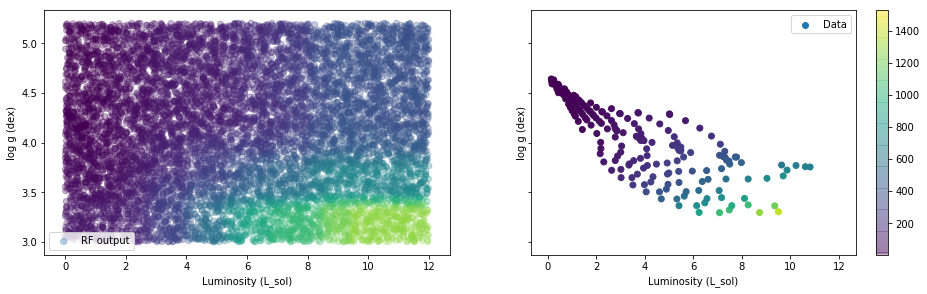

In [44]:
npts = 10000
Lsim = np.random.rand(npts) * 12
loggsim = np.random.rand(npts) * 2.2 + 3.0
teffsim = np.random.rand(npts) * 5000 + 3000
Xsim = np.array([teffsim, loggsim, Lsim]).T
ysim = regr.predict(Xsim)
fig, ax = plt.subplots(1, 2, figsize=[16,4.5], sharex=True, sharey=True)
tpmin, tpmax = df.tpE.min()*0.9, df.tpE.max()*1.1
CS = ax[1].scatter(df.L, df.logg, c=df.tpE, cmap='viridis', 
                   vmin=tpmin, vmax=tpmax,
                  label='Data')
CS = ax[0].scatter(Lsim, loggsim, c=ysim, cmap='viridis',
                  vmin=tpmin, vmax=tpmax, label='RF output', alpha=0.3)
ax[1].set_xlabel('Luminosity (L_sol)')
ax[1].set_ylabel('log g (dex)')
ax[0].set_xlabel('Luminosity (L_sol)')
ax[0].set_ylabel('log g (dex)')
ax[0].legend()
ax[1].legend()
fig.colorbar(CS)

Pretty happy with that performance but we should consider some limits in the final code that return warnings when sensible parameters are exceeded.